# Memory Advantage in the QEMC Algorithm?

**Ohad Lev**

**September 2023**

The QEMC algorithm doesn't offer a straightforward advantage in memory. Given a graph $G = (V, E)$ with $N = |V|$ nodes, the QEMC algorithm employs an Ansatz with $n = \log{N}$ qubits, that spans a Hilbert space of dimension $N$. Inside this Hilbert space, the statevectors of the Ansatzes reside, where each one of their amplitudes is associated with a node in the graph.

That looks promising - instead of allocating $O(N)$ bits to store $N$ amplitudes, we employ an Ansatz with $\log{N}$ qubits - an exponential improvement in memory consumption. However, we still need $O(N^2)$ (the dimension of a graph's adjacency matrix, can be reduced to $\Omega(N)$ for regular graphs that in turn are associated with sparse adjacency matrices) memory to merely store the graph on a classical computer. In addition, in each QEMC-iteration, the algorithm's cost function iterates over this adjacency matrix and calculates the cost with probability values taken from a probability distribution generated by multiple executions of the Ansatz. This probability distribution also consumes $O(N)$ memory, since every computational basis state (= node) is associated with a probability.

So, we have 2 memory bottlenecks:

1. Saving the graph's structure in memory.
2. Saving the probability distributions ($1$ probability distribution for each algorithm iteration) on the memory.

If we somehow manage to alleviate both, then (maybe) we have a quantum advantage in memory. Maybe, because this advantage is of QEMC compared to its classical counterpart, **cs**-QEMC. Comparisons to classical algorithms such as GW will be performed in the next steps, if we pass the current step.

Let's try to tackle the bottlenecks one by one.

## Bottleneck 1 - Graph Structure

It's not hard to think of a simple function that can be used to "construct" a graph "on the fly":

[(0, 1), (0, 2), (1, 2), (1, 3), (2, 3), (2, 4), (3, 4), (3, 5), (4, 5), (4, 6), (5, 6), (5, 7), (6, 7), (6, 0), (7, 0), (7, 1)]


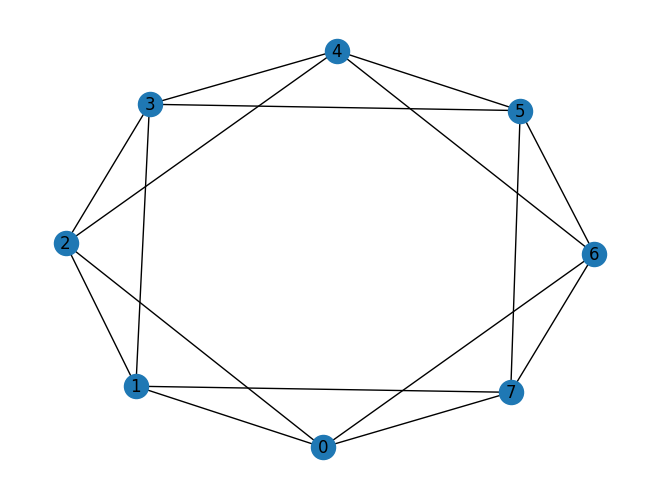

In [1]:
import networkx as nx


def edges_generator(node_index, num_nodes):

    gen_edges = []
    gen_edges.append((node_index, (node_index + 1) % num_nodes))
    gen_edges.append((node_index, (node_index + 2) % num_nodes))
    
    return gen_edges


num_nodes = 8

edges = []
for index in range(num_nodes):
    edges += edges_generator(index, num_nodes)

graph = nx.Graph(edges)
nx.draw(graph, with_labels=True)

print(edges)

Note that there is no need to generate or save the whole graph, we did it above for the sake of explanation. The QEMC algorithm can iterate over the $N$ node-indexes, and generate the corresponding edges for each node at a time, without saving them in memory.

Prima facie, this bottleneck is manageable with this "trick".

## Bottleneck 2 - Probability Distributions

Assume that we divide our set of nodes $V$ into <span style="color: blue;">blue</span> and <span style="color: red;">red</span> nodes. Let $B$ be the number of blue nodes. In an ideal QEMC probability distribution, we will have $B$ states with probability $\frac{1}{B}$. Assume (for now) that $B$ is known apriori. Then, one may think to save in memory only $B$ probability values, while automatically considering all other probabilities as $\frac{1}{N}$ (to imitate a uniform distribution over $N$ states). Now, if $B \approx O(N)$ - then we didn't progress at all. But, if $B \approx O(\sqrt{N})$, then might we achieve a polynomial advantage in memory? There are a few obstacles that come to my mind:

1. We don't know $B$ apriori. But for now let's igonore that.

2. I am not sure that saving just $B$ probabilities and considering the rest as $\frac{1}{N}$ is valuable. To see that, let's write here the cost function of the QEMC algorithm:

$$ C(G) = \sum^{}_{i < j} \Bigg( p_i + p_j - \frac{1}{B} \Bigg)^2 + \Bigg( |p_i - p_j| - \frac{1}{B} \Bigg)^2 $$

The first $B$ values we keep are due to randomized initialization. To push out a probability value out of the $B$ values we keep, the algorithm needs to tune the Ansatz's parameters such that this probability value will get below $\frac{1}{N}$. Let's try:

### Brute-Force MaxCut

In [3]:
# Brute Force

from classical_functions import brute_force_maxcut


bfmc = brute_force_maxcut(graph)

print(bfmc.optimal_partitions)
print(bfmc.best_score)

{'00110011', '10011001', '01100110', '11001100'}
12


### MaxCut approximation by the original QEMC

In [4]:
# Origianl QEMC

from qemc_implementation import QEMC


qemc_int = QEMC(graph)
qemc_int.construct_ansatz(6)
qemc_int.run()

QEMCResult(optimizer_result= message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 0.383544921875
       x: [ 6.227e+00  3.552e+00 ...  1.199e+00  5.052e+00]
    nfev: 448
   maxcv: 0.0, best_counts={'101': 13, '010': 64, '000': 140, '001': 98, '100': 158, '110': 64, '011': 193, '111': 294}, best_params=array([6.28414313, 3.50786722, 4.29384295, 5.3089616 , 4.89444537,
       3.52595433, 1.08526595, 5.93695988, 1.03459554, 0.54176333,
       1.79816105, 3.1746097 , 0.49396028, 2.1710035 , 0.36092136,
       4.20491966, 5.67781326, 6.01378711, 5.07135464, 2.84388103,
       4.12767402, 5.05586871, 6.23555549, 1.56082951, 3.87444406,
       3.46794056, 1.25572327, 6.09018096, 0.73987567, 5.99187372,
       3.57246374, 2.10984441, 6.38781119, 0.22924566, 2.59348587,
       3.91752061, 4.15892482, 5.85353675, 2.39232054, 2.69955663,
       0.67933023, 5.51217333, 4.11027165, 2.55011676, 3.15012742,
       4.63840597, 2.59175975, 0.41377888, 4.08323428, 3.14658

Achieved an optimal partition.

### Modified QEMC to test possible memory advantage

In [6]:
# Setting memory limitation to B = 4, 1024 shots

from qemc_memory_adv_implementation import QEMC_ML

qemc_ml_int = QEMC_ML(graph)
qemc_ml_int.construct_ansatz(6)
qemc_ml_int.run(memory_limitation=4)

QEMCResult(optimizer_result= message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 0.558563232421875
       x: [ 1.596e+00  4.262e+00 ...  6.673e-01  2.211e+00]
    nfev: 462
   maxcv: 0.0, best_counts={'111': 0.501953125, '000': 0.1650390625, '100': 0.0693359375, '001': 0.0673828125, '101': 0.125, '010': 0.125, '011': 0.125, '110': 0.125}, best_params=array([1.54266952, 4.24873155, 0.53386644, 4.87592764, 2.90125456,
       6.24943226, 1.85195943, 0.3202139 , 2.23171236, 5.18959974,
       4.71681997, 5.56904737, 2.80025354, 5.54963393, 5.88941804,
       6.16563761, 1.51613382, 1.92174028, 5.88970906, 1.60073248,
       2.30640427, 5.63045482, 4.42316226, 5.46858799, 1.00661482,
       0.46095521, 5.23673988, 2.56238782, 4.38001295, 1.49357243,
       1.82227426, 1.55376547, 5.53861499, 4.32995545, 4.19755944,
       1.51203357, 0.8611512 , 4.77650164, 6.04315949, 1.75763075,
       5.46270385, 0.13570337, 2.62689739, 4.37072133, 3.7723353 ,
       4.639

Achieved downgraded result (optimal cut = $12$, cut achieved = 8). Let's try to add shots:

In [7]:
qemc_ml_int = QEMC_ML(graph)
qemc_ml_int.construct_ansatz(6)
qemc_ml_int.run(shots=10_000, memory_limitation=4)

QEMCResult(optimizer_result= message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 0.63475456
       x: [ 1.729e+00  2.143e+00 ...  5.059e+00  2.463e+00]
    nfev: 514
   maxcv: 0.0, best_counts={'101': 0.2964, '010': 0.2065, '100': 0.1135, '111': 0.1109, '011': 0.125, '110': 0.125, '000': 0.125, '001': 0.125}, best_params=array([1.7386293 , 2.1652024 , 3.23166956, 3.39363941, 2.22029963,
       5.21452463, 3.24542037, 1.64058556, 4.14775472, 3.95729564,
       0.12977223, 4.20184043, 1.23478227, 4.48743293, 4.74307852,
       3.12664181, 5.02254666, 5.4440483 , 5.23567649, 0.39820212,
       3.05835149, 1.72487613, 5.01864306, 1.56800602, 3.90595229,
       6.03239993, 4.57521238, 6.22827057, 1.34179973, 6.12861175,
       3.54607777, 2.78438523, 5.23422058, 1.6516079 , 5.35713494,
       1.38112892, 2.0378324 , 0.85460024, 2.57875682, 5.69208916,
       3.40683001, 6.12465968, 2.80867856, 3.0695369 , 5.05929265,
       0.10738671, 5.59012168, 1.82054983,

Still, downgraded results.

It seems that our memory advantage scheme doesn't work properly, but it should be further checked.